In [1]:
!nvidia-smi

Sat Mar 11 00:04:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.50       Driver Version: 472.50       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| 30%   42C    P8    15W / 320W |   1818MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Settings

In [2]:
# 필요 모델 호출
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import math
import time
import random
import tensorflow as tf

In [3]:
def seed_everything(seed: int = 2022):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [4]:
class config:
    seed = 2022

In [5]:
seed_everything(config.seed)
# seed = 2022
# tf.random.set_seed(seed)

# Load Dataset

In [6]:
# 이미지 로드
imglist = os.listdir('/Users/User/303/COVID-19_Radiography_Dataset/COVID/images/')
def load_image(path):
    image_list = np.zeros((len(imglist), 128, 128))
    for i in range(len(imglist)):
        img = Image.open('/Users/User/303/COVID-19_Radiography_Dataset/COVID/images/'+str(imglist[i])).convert('L')
        image_list[i] = img
    return image_list

In [7]:
posi = load_image('/Users/User/303/COVID-19_Radiography_Dataset/COID/images/*.png')
posi = posi.astype('float32')/255.
print(posi.shape)

(3616, 128, 128)


# Train Validation Test Split

In [8]:
from sklearn.model_selection import train_test_split

X_trainval, x_test = train_test_split(posi, test_size=0.2, random_state=42)
x_train, x_val = train_test_split(X_trainval, train_size=0.75, random_state=42)

In [9]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(2169, 128, 128)
(723, 128, 128)
(724, 128, 128)


# Noise

In [10]:
def noisy(noise_typ,image):
    #Gaussian Noisy
    if noise_typ == "gauss":
        
        noisy = image + 0.1 *  np.random.normal(loc=0,scale=1.,size=image.shape)
        return noisy
    #Salt & Pepper Noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.05
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[tuple(coords)] = 1
        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[tuple(coords)] = 0
        return out

    # Speckle Noisy
    elif noise_typ =="speckle":
        noisy = np.random.normal(loc=0,scale=1.,size=image.shape)
        noisy = image+ image * 0.1 *noisy
        return noisy
    # Poisson Noisy
    elif noise_typ == "poisson":
        
        noisy = image + 0.1 *  np.random.poisson(lam=1.0,size=image.shape)
        return noisy

In [11]:
def MAE(img1, img2):
    D = np.array(img1 - img2, dtype=np.float64)
    D[:, :] = np.abs(D[:, :])
    MAE = D.sum()/img1.size
    return MAE

def PSNR(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [12]:
from skimage.restoration import denoise_nl_means, denoise_bilateral
from scipy.signal import medfilt2d
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage.util import random_noise

def Meanfilter(noisy_test_data):
    meanfilter = []
    for i in range(len(noisy_test_data)):
         meanfilter.append(cv2.blur(noisy_test_data[i],(3,3)))
    meanfilter = np.array(meanfilter)
    return meanfilter
    
def Medianfilter(noisy_test_data):
    medianfilter = []
    for i in range(len(noisy_test_data)):
        medianfilter.append(medfilt2d(noisy_test_data[i],(3,3)))
    medianfilter = np.array(medianfilter)
    return medianfilter


def lee_filter(img):
    lee = []
    for i in range(len(img)):
        img_mean = uniform_filter(img[i])
        img_sqr_mean = uniform_filter(img[i]**2)
        img_variance = img_sqr_mean - img_mean**2
        
        overall_variance = variance(img[i])
        
        img_weights = (img_variance**2) / ((img_variance**2) + (overall_variance**2))
        img_output = img_mean + img_weights * (img[i] - img_mean)
        
        lee.append(img_output)
    lee = np.array(lee)
    return lee

In [13]:
# Add Noisy
x_train_sp_noisy = noisy("poisson",x_train)
x_val_sp_noisy = noisy("poisson",x_val)

x_test_sp_noisy = noisy("poisson",x_test)

x_train_sp_noisy=x_train_sp_noisy.clip(0,1)
x_val_sp_noisy=x_val_sp_noisy.clip(0,1)

x_test_sp_noisy=x_test_sp_noisy.clip(0,1)
x_train_sp_noisy[0]

array([[0.03529412, 0.12352941, 0.02352941, ..., 0.21176471, 0.11176471,
        0.02352941],
       [0.13137255, 0.11960784, 0.31960784, ..., 0.11176471, 0.01176471,
        0.02352941],
       [0.22745098, 0.31568628, 0.11568628, ..., 0.00784314, 0.10784314,
        0.22352941],
       ...,
       [0.01568628, 0.2       , 0.00392157, ..., 0.10392157, 0.1       ,
        0.31568628],
       [0.01568628, 0.2       , 0.20392157, ..., 0.10392157, 0.2       ,
        0.01568628],
       [0.11568628, 0.4       , 0.10392157, ..., 0.10392157, 0.1       ,
        0.01568628]])

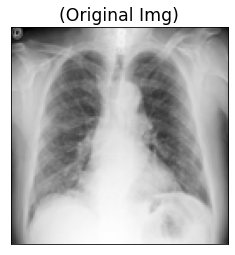

In [14]:
# Original Image
ax = plt.subplot()
plt.imshow(x_test[5], cmap=plt.cm.gray)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("(Original Img)", position=(0.5,-0.12),fontsize = "xx-large")
plt.show()

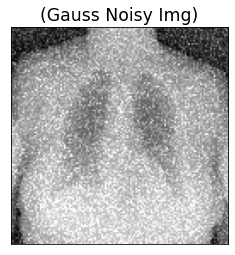

In [15]:
# Salt & Pepper Noisy Image
ax = plt.subplot()
plt.imshow(x_test_sp_noisy[1], cmap=plt.cm.gray)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("(Gauss Noisy Img)", position=(0.5,-0.12),fontsize = "xx-large")
plt.show()

CPU 시간 : 0.06248641014099121


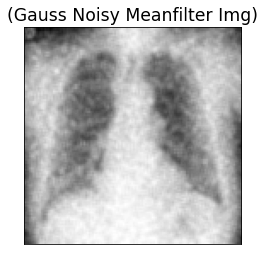

In [16]:
# MeanFilter Image
start = time.time()
mean_x_test_sp_noisy = Meanfilter(x_test_sp_noisy)
end = time.time()
Meantime= end - start
print("CPU 시간 : "+str(Meantime))

ax = plt.subplot()
plt.imshow(mean_x_test_sp_noisy[5], cmap=plt.cm.gray)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("(Gauss Noisy Meanfilter Img)", position=(0.5,-0.12),fontsize = "xx-large")
plt.show()

CPU 시간 : 0.9060392379760742


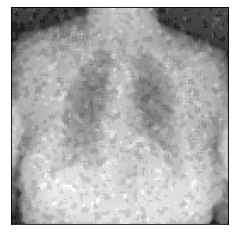

In [17]:
# MedianFilter Image
start = time.time()
median_x_test_sp_noisy = Medianfilter(x_test_sp_noisy)
end = time.time()
Mediantime= end - start
print("CPU 시간 : "+str(Mediantime))

ax = plt.subplot()
plt.imshow(median_x_test_sp_noisy[1], cmap=plt.cm.gray)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


In [18]:
#Convolution Neural Networks Filter Image
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, UpSampling2D
# Convolution Auto Encoder Filter Image
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import optimizers
from keras.models import Model

In [19]:
# Convolution Auto Encoder Filter Image
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D ,LeakyReLU,ReLU,Concatenate
from keras import optimizers
from keras.models import Model

In [20]:
x_train_sp_noisy= tf.convert_to_tensor(x_train_sp_noisy)
x_val_sp_noisy= tf.convert_to_tensor(x_val_sp_noisy)
x_test_sp_noisy= tf.convert_to_tensor(x_test_sp_noisy)

x_train_sp_noisy.dtype

x_train_sp_noisy[0]

<tf.Tensor: shape=(128, 128), dtype=float64, numpy=
array([[0.03529412, 0.12352941, 0.02352941, ..., 0.21176471, 0.11176471,
        0.02352941],
       [0.13137255, 0.11960784, 0.31960784, ..., 0.11176471, 0.01176471,
        0.02352941],
       [0.22745098, 0.31568628, 0.11568628, ..., 0.00784314, 0.10784314,
        0.22352941],
       ...,
       [0.01568628, 0.2       , 0.00392157, ..., 0.10392157, 0.1       ,
        0.31568628],
       [0.01568628, 0.2       , 0.20392157, ..., 0.10392157, 0.2       ,
        0.01568628],
       [0.11568628, 0.4       , 0.10392157, ..., 0.10392157, 0.1       ,
        0.01568628]])>

In [21]:
epochs = 100
inChannel = 1
x, y = 128, 128
batch_size=9

In [22]:
act=ReLU()

In [23]:
#Convolution Neural Networks Filter Image
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, UpSampling2D
# Convolution Auto Encoder Filter Image
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import optimizers
from keras.models import Model

In [24]:
# Encoder
input_img = Input(shape=(x,y,inChannel))
conv1 = Conv2D(16, (3,3), activation="relu", padding='same',name='encoder1_cov')(input_img) 
pool1 = MaxPooling2D(pool_size=(2,2),name='maxpool1')(conv1) 
conv2 = Conv2D(32, (3,3), activation="relu", padding='same',name='encoder2_cov')(pool1)
pool2 = MaxPooling2D(pool_size=(2,2),name='maxpool2')(conv2) 
encoded = Conv2D(64, (3,3), activation='relu', padding='same',name='encoder3_cov')(pool2) 

# Decoder

conv4 = Conv2D(64, (3,3), activation="relu", padding='same',name='decoder1_cov')(encoded)
up1 = UpSampling2D((2,2),name='up1')(conv4)
conv5 = Conv2D(32, (3,3), activation="relu", padding='same',name='decoder2_cov')(up1)
up2 = UpSampling2D((2,2),name='up2')(conv5)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same',name='decoder3_cov')(up2)

In [25]:
def PSNR1(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [26]:
def SSIM1(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [27]:
# CAEFilter Image
autoencoder_sp = Model(input_img, decoded)
autoencoder_sp.compile(loss='mean_squared_error',optimizer=optimizers.Adam(),metrics=[PSNR1,SSIM1],run_eagerly=True)
autoencoder_sp.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 encoder1_cov (Conv2D)       (None, 128, 128, 16)      160       
                                                                 
 maxpool1 (MaxPooling2D)     (None, 64, 64, 16)        0         
                                                                 
 encoder2_cov (Conv2D)       (None, 64, 64, 32)        4640      
                                                                 
 maxpool2 (MaxPooling2D)     (None, 32, 32, 32)        0         
                                                                 
 encoder3_cov (Conv2D)       (None, 32, 32, 64)        18496     
                                                                 
 decoder1_cov (Conv2D)       (None, 32, 32, 64)        36928 

In [28]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler,Callback

#경로 바꿔주기
filename = './checkpoint/CDAE_poisson_42_test.ckpt'
checkpoint = ModelCheckpoint(filename,             
                             monitor= 'val_loss',
                             save_weights_only=True,
                             verbose=1,           
                             save_best_only=True,  
                             mode='min'         
                            )


In [29]:
x_train_cae = tf.convert_to_tensor(x_train)
x_train_cae = tf.reshape(x_train_cae,(2169, 128, 128,1))

x_val_cae = tf.convert_to_tensor(x_val)
x_val_cae = tf.reshape(x_val_cae,(723, 128, 128,1))


x_test_cae = tf.convert_to_tensor(x_test)
x_test_cae = tf.reshape(x_test_cae,(724, 128, 128,1))

x_train_cae_sp_noisy = tf.reshape(x_train_sp_noisy,[-1, 128, 128, 1])
x_val_cae_sp_noisy = tf.reshape(x_val_sp_noisy,[-1, 128, 128, 1])
x_test_cae_sp_noisy = tf.reshape(x_test_sp_noisy,[-1, 128, 128,1])

In [30]:
# autoencodersp_train = autoencoder_sp.fit(x_train_cae_sp_noisy, x_train_cae, 
#                                         batch_size=batch_size, 
#                                         epochs=epochs, 
#                                         verbose=2,
#                                         validation_data=(x_val_cae_sp_noisy, x_val_cae)
#                                         ,callbacks=[checkpoint])

In [31]:
import pandas as pd

In [32]:
# hist_df = pd.DataFrame(autoencodersp_train.history) 
# hist_df

In [33]:
# hist_df.to_csv('./csv/cdae_poisson_42.csv')

In [34]:
autoencoder_sp.load_weights(filename)

In [35]:
start = time.time()
cae_x_test_sp_noisy = autoencoder_sp.predict(x_test_cae_sp_noisy,batch_size=batch_size)
print(cae_x_test_sp_noisy.shape)
end = time.time()
Caetime= end - start
print("CPU 시간 : "+str(Caetime))
cae_x_test_sp_noisy = tf.reshape(cae_x_test_sp_noisy,[724, 128, 128])

81/81 [==============================] - 2s 5ms/step
(724, 128, 128, 1)
CPU 시간 : 1.6558642387390137


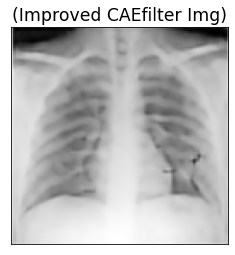

In [36]:
ax = plt.subplot()
plt.imshow(cae_x_test_sp_noisy[21], cmap=plt.cm.gray)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("(Improved CAEfilter Img)", position=(0.5,-0.12),fontsize = "xx-large")
plt.show()

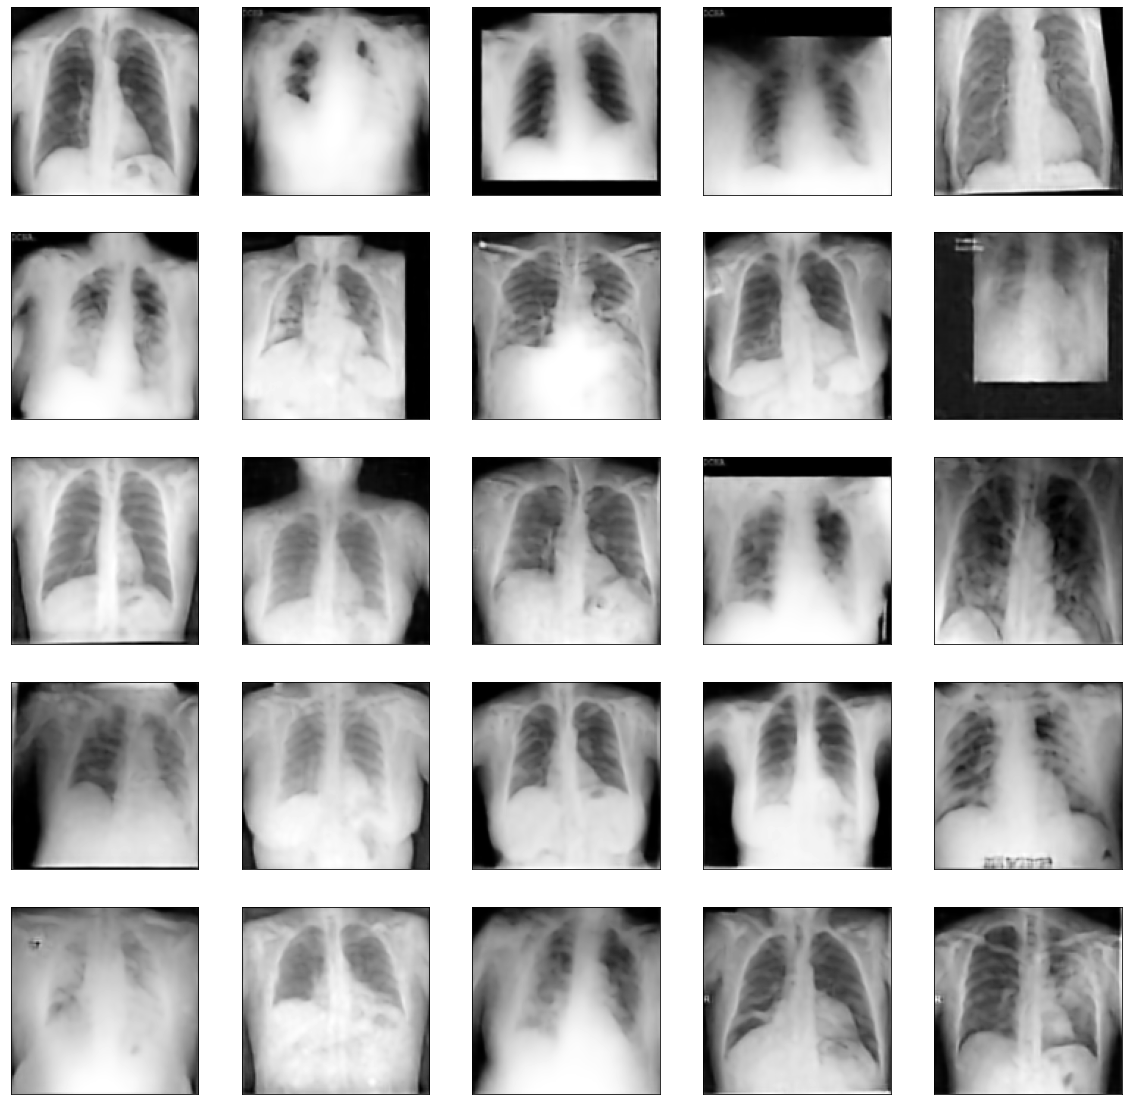

In [623]:
# 5x5 서브플롯 생성
fig, axs = plt.subplots(5, 5, figsize=(20, 20))

# 각 서브플롯에 이미지 출력
for i, ax in enumerate(axs.flat):
    ax.imshow(cae_x_test_sp_noisy[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [624]:
# data = pd.read_csv("./csv/de_cdae_gauss_batch9_10회_사용X_51.csv")
# data

In [625]:
# loss = data['loss'].tolist()
# val_loss = data['val_loss'].tolist()

In [626]:
# #cae_loss = autoencodersp_train.history['loss']
# #cae_val_loss = autoencodersp_train.history['val_loss']
# epochs = range(100)
# plt.figure()
# plt.plot(epochs, loss, 'b', label="train")
# plt.plot(epochs, val_loss, 'g', label="validation")
# plt.xlabel("epoch")
# plt.ylabel("loss")
# plt.legend()
# plt.show()

In [627]:
# cae_loss = autoencodersp_train.history['PSNR1']
# cae_val_loss = autoencodersp_train.history['val_PSNR1']
# epochs = range(100)
# plt.figure()
# plt.plot(epochs, cae_loss, 'b', label="train")
# plt.plot(epochs, cae_val_loss, 'r', label="validation")
# plt.xlabel("epoch")
# plt.ylabel("PSNR")
# plt.legend()
# plt.show()

In [628]:
# cae_loss = autoencodersp_train.history['SSIM1']
# cae_val_loss = autoencodersp_train.history['val_SSIM1']
# epochs = range(100)
# plt.figure()
# plt.plot(epochs, cae_loss, 'b', label="train")
# plt.plot(epochs, cae_val_loss, 'r', label="validation")
# plt.xlabel("epoch")
# plt.ylabel("SSIM")
# plt.legend()
# plt.show()

In [629]:
from skimage.metrics import structural_similarity as ssim

In [630]:
cae_x_test_sp_noisy = cae_x_test_sp_noisy.numpy()

In [631]:
psnr_mean = []
mae_mean = []
psnr_median = []
mae_median = []
# psnr_nlmeans = []
# mae_nlmeans = []
# psnr_bilateral = []
# mae_bilateral = []
# psnr_wavelet = []
# mae_wavelet = []

psnr_cae = []
mae_cae = []



ssim_mean=[]
ssim_median=[]
# ssim_nlmeans=[]
# ssim_bilateral=[]
# ssim_wavelet=[]
ssim_cae=[]

for i in range(len(x_test_sp_noisy)):
    mae_mean.append(MAE(mean_x_test_sp_noisy[i],x_test[i]))
    mae_median.append(MAE(median_x_test_sp_noisy[i],x_test[i]))
#     mae_nlmeans.append(MAE(nlmeans_x_test_sp_noisy[i],x_test[i]))
#     mae_bilateral.append(MAE(bilateral_x_test_sp_noisy[i],x_test[i]))  
    mae_cae.append(MAE(cae_x_test_sp_noisy[i],x_test[i]))
    
    psnr_mean.append(PSNR(mean_x_test_sp_noisy[i],x_test[i]))
    psnr_median.append(PSNR(median_x_test_sp_noisy[i],x_test[i]))
#     psnr_nlmeans.append(PSNR(nlmeans_x_test_sp_noisy[i],x_test[i]))
#     psnr_bilateral.append(PSNR(bilateral_x_test_sp_noisy[i],x_test[i]))
    
    psnr_cae.append(PSNR(cae_x_test_sp_noisy[i],x_test[i]))
    
    ssim_mean.append(ssim(x_test[i], mean_x_test_sp_noisy[i]))
    ssim_median.append(ssim(x_test[i], median_x_test_sp_noisy[i]))
#     ssim_nlmeans.append(ssim(x_test[i], nlmeans_x_test_sp_noisy[i]))
#     ssim_bilateral.append(ssim(x_test[i], bilateral_x_test_sp_noisy[i]))
    
    ssim_cae.append(ssim(x_test[i], cae_x_test_sp_noisy[i]))

In [632]:
print("About Gauss Noisy")
print("Mean Filter : MAE = " +  str(np.mean(mae_mean)) + " & PSNR = " + str(np.mean(psnr_mean))+" & SSIM = "+str(np.mean(ssim_mean)))
print("Median Filter : MAE = " +  str(np.mean(mae_median)) + " & PSNR = " + str(np.mean(psnr_median))+" & SSIM = "+str(np.mean(ssim_median)))
#print("Bilateral Filter : MAE = " +  str(np.mean(mae_bilateral)) + " & PSNR = " + str(np.mean(psnr_bilateral))+" & SSIM = "+str(np.mean(ssim_bilateral)))
#print("NL Means Filter : MAE = " +  str(np.mean(mae_nlmeans)) + " & PSNR = " + str(np.mean(psnr_nlmeans))+" & SSIM = "+str(np.mean(ssim_nlmeans)))
#print("Wavelet Filter : MAE = " +  str(np.mean(mae_wavelet)) + " & PSNR = " + str(np.mean(psnr_wavelet))+" & SSIM = "+str(np.mean(ssim_wavelet)))
print("CDAE Filter : MAE = " +  str(np.mean(mae_cae)) + " & PSNR = " + str(np.mean(psnr_cae))+" & SSIM = "+str(np.mean(ssim_cae)))


About Gauss Noisy
Mean Filter : MAE = 0.09370676173068516 & PSNR = 19.884525125122558 & SSIM = 0.8328051937532237
Median Filter : MAE = 0.08354041603035578 & PSNR = 20.34422506411942 & SSIM = 0.75406011997555
CDAE Filter : MAE = 0.013217302978933074 & PSNR = 34.16561208342364 & SSIM = 0.9625771488052605
